In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 10 14:44:35 2021

@author: wendsonbarbosa

Note: Daniel Sanchez, who was in the team earlier, cleaned up the data - first lines of this code.
"""

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Directory path where data is located
path = "/Users/anton/Google Drive/OSU/Erdos-FallProgram2021/Root_Project"      ### My PC

# DATA READING
data = pd.read_csv("%s/Root_Insurance_data.csv" % path)

# DATA CLEANING
data = data.replace(['unknown', 'Y', 'N', 'M', 'S'], [2, 1, 0, 1, 0])
data['click'] = data['click'].astype(int)  

# TRAIN-TEST SPLIT
train, test = train_test_split(data, random_state=42, test_size=.2, stratify = data['click'])    
data.head()

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,2,2,1,1,10.0,2,0,0
1,1,3,1,1,10.0,5,0,0
2,1,3,2,1,10.0,5,0,0
3,0,3,2,0,10.0,4,0,0
4,2,2,2,0,10.0,2,0,0


In [2]:
# SEPARATES GROUPS OF CUSTOMERS - RETURN EACH OF THE 36 DEMOGRAPHIC GROUPS AND THE RESPECTIVE STATISTICS
def separate_groups_training(data_frame):  
    groups = []
    groups_index = []
    for insurance_label in range(0,3):
        for car_label in range(1,4):
            for n_drivers in range(1,3):
                for marriage_label in range(2):
                    A1 = data_frame.loc[data_frame['Currently Insured'] == insurance_label]
                    A2 = A1.loc[A1['Number of Vehicles'] == car_label]
                    A3 = A2.loc[A2['Number of Drivers'] == n_drivers]
                    A4 = A3.loc[A3['Marital Status'] == marriage_label]
                    A5 = A4.mean()
                    
                    if np.isnan(A5['rank']): 
                        continue
                    
                    groups_index.append([insurance_label,car_label,n_drivers,marriage_label])
                    groups.append(A5)
                        
    groups_concat = pd.concat([df for df in groups], axis=1).T
    groups_concat = groups_concat.rename(columns={'rank': 'ave_rank', 'click': 'click_prob', 'policies_sold': 'sell_prob'})
    #return (groups_concat, groups_index)
    return groups_concat


# SEPARATES GROUPS OF CUSTOMERS BY RANKS - RETURN EACH OF THE 180 (36 CUSTOMER TYPE * 5 POSSIBLE RANK) POSSIBILITIES AND THE RESPECTIVE STATISTICS  
def separate_groups_by_rank(data_frame):  
    count = 0
    groups = []
    groups_index = []
    for rank_label in range(1,6):
        for insurance_label in range(0,3):
            for car_label in range(1,4):
                for n_drivers in range(1,3):
                    for marriage_label in range(2):                
                        A1 = data_frame.loc[data_frame['Currently Insured'] == insurance_label]
                        A2 = A1.loc[A1['Number of Vehicles'] == car_label]
                        A3 = A2.loc[A2['Number of Drivers'] == n_drivers]
                        A4 = A3.loc[A3['Marital Status'] == marriage_label]
                        A5 = A4.loc[A4['rank']==rank_label]
                        A6 = A5.mean()     
                        count = count + 1
                        if np.isnan(A6['rank']): 
                            continue
                        
                        groups_index.append(count-1)
                        #groups_index.append([insurance_label,car_label,n_drivers,marriage_label])
                        groups.append(A6)
                        

    groups_concat = pd.concat([df for df in groups], axis=1).T
    groups_concat = groups_concat.rename(columns={'click': 'click_prob', 'policies_sold': 'sell_prob'})
    return (groups_concat, groups_index)

In [4]:
# ALL POSSIBLE GROUPS OF CUSTOMERS INCLUDING ALL POSSIBLE RANK 
all_groups = []
for insurance_label in range(0,3):
    for car_label in range(1,4):
        for n_drivers in range(1,3):
            for marriage_label in range(2):
                for rank_index in range(1,6):
                    all_groups.append(np.array([insurance_label,car_label,n_drivers,marriage_label,rank_index]))

                    
                    
# CREATING MASK
# Multiplying training data by the mask to make features distinguishable when
# creating polynomial features - It usually helps a little.
mask = np.random.uniform(0.1,1,4)
mask = np.ones((1,4))
mask = np.insert(mask,4,1)                

In [12]:
# CROSS-VALIDATION FOR PARAMETER OPTIMIZATION 

alpha_iter = 100
gamma_iter = 100

kfold = KFold(n_splits = 5, shuffle = True, random_state = 614)
RMSEs = np.empty((5,alpha_iter,gamma_iter))
AP = np.empty((5,alpha_iter,gamma_iter))
i = 0
for train_index, valid_index in kfold.split(train):
    
    train_train = train.iloc[train_index,:]
    train_valid = train.iloc[valid_index,:]    
    
    groups_train_train = separate_groups_training(train_train)
    X_train_train = np.asarray(groups_train_train[['Currently Insured', 'Number of Vehicles', 'Number of Drivers', 'Marital Status','ave_rank']])
    Y_train_train = np.asarray(groups_train_train[['click_prob']])
    
    X_train_train = [i*mask for i in X_train_train]
    
    groups_train_valid, validation_group_index = separate_groups_by_rank(train_valid)
    X_train_valid = np.asarray(groups_train_valid[['Currently Insured', 'Number of Vehicles', 'Number of Drivers', 'Marital Status','rank']])
    Y_train_valid = np.asarray(groups_train_valid[['click_prob']])
    
    X_train_valid = [i*mask for i in X_train_valid]
        
    
    alpha__range=np.geomspace(1e-8,1e4,alpha_iter)
    gamma__range=np.geomspace(1e-6,1e1,gamma_iter)
    rmse__alpha = []
    j = 0
    for alpha__ in alpha__range:
        k = 0
        for gamma__ in gamma__range:

            # # Creating initial polynomial features
            poly = PolynomialFeatures(1)
  
            # # Creating model object
            # Model Parameters
            method = 'KR'
            alpha_ = alpha__
            kernel_ = 'poly'
            degree_ = 5
            gamma_ = gamma__
            if method == 'KR':
                output_model = KernelRidge(alpha=alpha_,kernel=kernel_,degree=degree_,gamma=gamma_)
            elif method == 'RBF':
                output_model = KernelRidge(alpha=alpha_,kernel='rbf',gamma=gamma_)
            elif method == 'R':
                output_model = sklearn.linear_model.Ridge(alpha=alpha_)
            
            features_train = poly.fit_transform(X_train_train)
            
            # =============================================================================
            # # Fitting the model
            # =============================================================================
            output_model.fit(features_train,Y_train_train)
            
            # =============================================================================
            # # Validation
            features_val = poly.fit_transform(X_train_valid)
            pred = output_model.predict(features_val)
            pred = np.where(pred<0,0,pred)
        
            Y_train_valid_bool=np.where(Y_train_valid.reshape(-1)<0.5,0,1)
            pred_boll=np.where(pred.reshape(-1)<0.5,0,1)
            AP[i,j,k]=average_precision_score(Y_train_valid_bool,pred)
            
            RMSEs[i,j,k] = mean_squared_error(Y_train_valid, pred)**0.5
            
            k = k + 1
        
        j = j + 1

    i = i + 1

RMSE_ave = np.mean(RMSEs, axis = 0)
AP_ave = np.mean(AP, axis = 0)

optimal_alpha = alpha__range[np.argmax(np.mean(AP, axis = 0))%alpha_iter]
optimal_gamma = gamma__range[np.argmax(np.mean(AP, axis = 0))%gamma_iter]



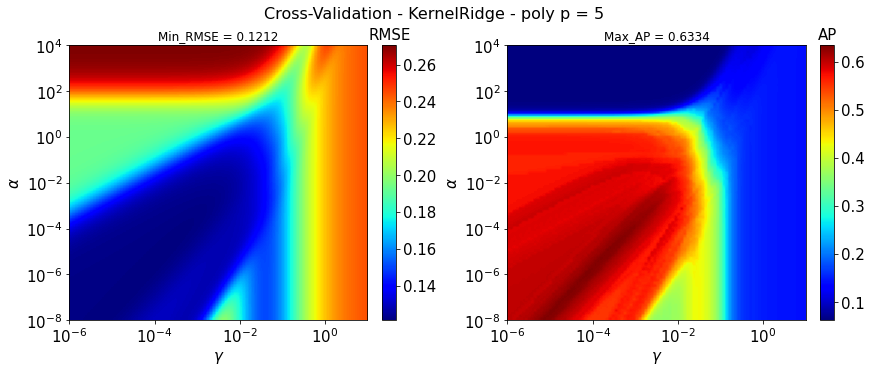

In [13]:
def fake_log(x, pos):
    'The two args are the value and tick position'
    return r'$10^{%d}$' % (x)

fig, ax = plt.subplots(1,2,figsize=(12,5),constrained_layout = True)

im1 = ax[0].imshow(RMSE_ave,aspect = "auto", cmap="jet", extent=[-6,1,4,-8])
ax[0].set_ylabel("$\\alpha$", fontsize = 15)
ax[0].set_xlabel("$\\gamma$", fontsize = 15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_title("Min_RMSE = %.4f" % np.min(RMSE_ave))
cbar1 = fig.colorbar(im1,ax=ax[0])
cbar1.ax.set_title('RMSE', size = 15)
cbar1.ax.tick_params(labelsize=15) 
ax[0].xaxis.set_major_formatter(fake_log)
ax[0].yaxis.set_major_formatter(fake_log)
ax[0].set_xlim(-6,1)
ax[0].set_ylim(-8,4)

im2= ax[1].imshow(AP_ave,aspect = "auto", cmap="jet",  extent=[-6,1,4,-8])
ax[1].set_ylabel("$\\alpha$", fontsize = 15)
ax[1].set_xlabel("$\\gamma$", fontsize = 15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].set_title("Max_AP = %.4f" % np.max(AP_ave))
ax[1].xaxis.set_major_formatter(fake_log)
ax[1].yaxis.set_major_formatter(fake_log)
cbar2 = fig.colorbar(im2,ax=ax[1])
cbar2.ax.set_title('AP', size = 15)
cbar2.ax.tick_params(labelsize=15) 
ax[1].set_xlim(-6,1)
ax[1].set_ylim(-8,4)

if method == 'KR':
    fig.suptitle("Cross-Validation - KernelRidge - poly p = %d " % degree_, fontsize=16)
    plt.savefig("%s/Cross-Validation-KernelRidge-poly_p=%d-RMSE.pdf" % (path,degree_),  bbox_inches='tight')

elif method == 'RBF':
    fig.suptitle("Cross-Validation - KernelRidge - Gaussian RBF", fontsize=16)
    plt.savefig("%s/Cross-Validation-KernelRidge-GaussianRBF-RMSE.pdf" % path,  bbox_inches='tight')
    
elif method == 'R':
    fig.suptitle("Cross-Validation \n Ridge" , fontsize=16)
    plt.savefig("%s/Cross-Validation-Ridge-RMSE.pdf" % path,  bbox_inches='tight')

plt.show()

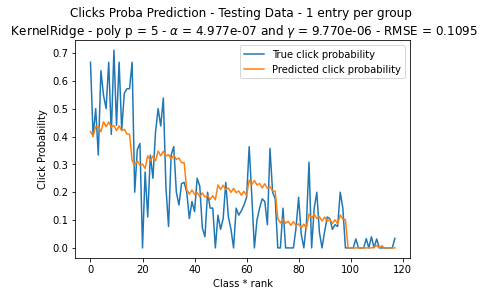

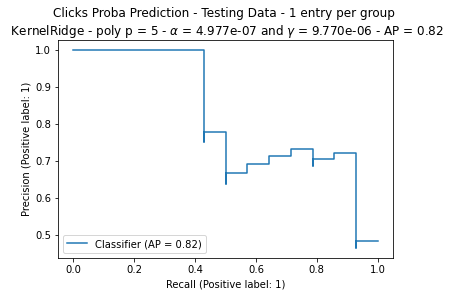

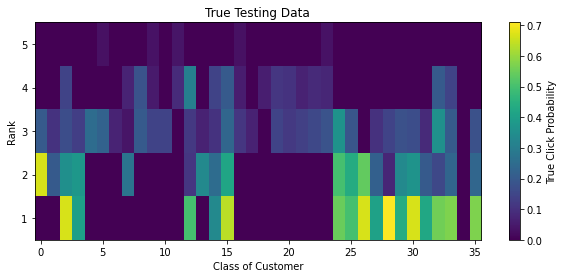

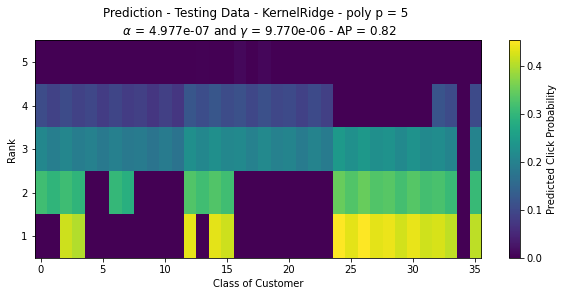

In [10]:
# TRAINING AND TESTING DATA

groups_train = separate_groups_training(train)
X_train = np.asarray(groups_train[['Currently Insured', 'Number of Vehicles', 'Number of Drivers', 'Marital Status','ave_rank']])
Y_train = np.asarray(groups_train[['click_prob']])

X_train = [i*mask for i in X_train]

groups_test, test_group_index = separate_groups_by_rank(test)
X_test = np.asarray(groups_test[['Currently Insured', 'Number of Vehicles', 'Number of Drivers', 'Marital Status','rank']])
Y_test = np.asarray(groups_test[['click_prob']])

X_test = [i*mask for i in X_test]

# TRAINING

if method == 'KR':
    output_model = KernelRidge(alpha=optimal_alpha,kernel=kernel_,degree=degree_,gamma=optimal_gamma)
elif method == 'RBF':
    output_model = KernelRidge(alpha=optimal_alpha,kernel='rbf',gamma=optimal_gamma)
elif method == 'R':
    output_model = sklearn.linear_model.Ridge(alpha=optimal_alpha)

features_train = poly.fit_transform(X_train)
output_model.fit(features_train,Y_train)

# TESTING

features_test = poly.fit_transform(X_test)
pred = output_model.predict(features_test)
pred = np.where(pred<0,0,pred)

rmse = mean_squared_error(Y_test, pred)**0.5


plt.plot(Y_test, label = "True click probability")
plt.plot(pred, label = "Predicted click probability")
plt.legend()
plt.xlabel("Class * rank")
plt.ylabel("Click Probability")

if method == 'KR':
    plt.title("Clicks Proba Prediction - Testing Data - 1 entry per group \n KernelRidge - poly p = %d - $\\alpha$ = %.3e and $\\gamma$ = %.3e - RMSE = %.4f" % (degree_, optimal_alpha, optimal_gamma, rmse) )
    plt.savefig("%s/ClickProba_vs_demographics-KernelRidge-poly_p=%d.pdf" % (path,degree_),  bbox_inches='tight')

elif method == 'RBF':
    plt.title("Clicks Proba Prediction - Testing Data - 1 entry per group \n KernelRidge - Gaussian RBF - $\\alpha$ = %.3e and $\\gamma$ = %.3e - RMSE = %.4f" % (optimal_alpha, optimal_gamma, rmse) )
    plt.savefig("%s/ClickProba_vs_demographics-KernelRidge-GaussianRBF.pdf" % path,  bbox_inches='tight')

elif method == 'R':
    plt.title("Clicks Proba Prediction - Testing Data - 1 entry per group \n Ridge - $\\alpha$ = %.3e - RMSE = %.4f" % (optimal_alpha, rmse) )    
    plt.savefig("%s/ClickProba_vs_demographics-Ridge.pdf" % path,  bbox_inches='tight')

plt.show()



Y_test_bool=np.where(Y_test.reshape(-1)<0.5,0,1)
pred_boll=np.where(pred.reshape(-1)<0.5,0,1)
AP = average_precision_score(Y_test_bool,pred)


display = PrecisionRecallDisplay.from_predictions(Y_test_bool,pred)#, name="LinearSVC")
if method == 'KR':
    plt.title("Clicks Proba Prediction - Testing Data - 1 entry per group \n KernelRidge - poly p = %d - $\\alpha$ = %.3e and $\\gamma$ = %.3e - AP = %.2f" % (degree_, optimal_alpha, optimal_gamma, AP) )
    plt.savefig("%s/Precision_Recall-1EntryPerGroup-KernelRidge-poly_p=%d.pdf" % (path,degree_),  bbox_inches='tight')

elif method == 'RBF':
    plt.title("Clicks Proba Prediction - Testing Data - 1 entry per group \n KernelRidge - Gaussian RBF - $\\alpha$ = %.3e and $\\gamma$ = %.3e - AP = %.2f" % (optimal_alpha, optimal_gamma, AP) )
    plt.savefig("%s/Precision_Recall-1EntryPerGroup-KernelRidge-GaussianRBF.pdf" % path,  bbox_inches='tight')

elif method == 'R':
    plt.title("Clicks Proba Prediction - Testing Data - 1 entry per group \n Ridge - $\\alpha$ = %.3e - AP = %.2f" % (optimal_alpha, AP) )    
    plt.savefig("%s/Precision_Recall-1EntryPerGroup-Ridge.pdf" % path,  bbox_inches='tight')

plt.show()



pred_click_p = np.zeros(5*36)
for i in range(len(pred)):
    pred_click_p[test_group_index[i]] = pred[i,0]

true_click_p = np.zeros(5*36)
for i in range(len(Y_test)):
    true_click_p[test_group_index[i]] = Y_test[i,0]
    
    
fig = plt.figure(figsize=(10,4))
plt.imshow(np.asarray(true_click_p).reshape(5,36),aspect = "auto", extent=[-0.5,35.5,5.5,0.5])
plt.ylim(0.5,5.5)
plt.xlabel("Class of Customer")
plt.ylabel("Rank")
plt.colorbar(label = "True Click Probability")
plt.title("True Testing Data")
plt.show()   
    
fig = plt.figure(figsize=(10,4))
plt.imshow(np.asarray(pred_click_p).reshape(5,36),aspect = "auto", extent=[-0.5,35.5,5.5,0.5])
plt.ylim(0.5,5.5)
plt.xlabel("Class of Customer")
plt.ylabel("Rank")
plt.colorbar(label = "Predicted Click Probability")
if method == 'KR':
    plt.title("Prediction - Testing Data - KernelRidge - poly p = %d \n $\\alpha$ = %.3e and $\\gamma$ = %.3e - AP = %.2f" % (degree_, optimal_alpha, optimal_gamma, AP) )
    plt.savefig("%s/Click_prediction_vs_AvailableDemographicsPerLabel-KernelRidge-poly_p=%d.pdf" % (path,degree_),  bbox_inches='tight')

elif method == 'RBF':
    plt.title("Prediction - Testing Data - KernelRidge - Gaussian RBF \n $\\alpha$ = %.3e and $\\gamma$ = %.3e - AP = %.2f" % (optimal_alpha, optimal_gamma, AP) )
    plt.savefig("%s/Click_prediction_vs_AvailableDemographicsPerLabel-KernelRidge-GaussianRBF.pdf" %path,  bbox_inches='tight')

elif method == 'R':
    plt.title("Prediction - Testing Data - Ridge \n $\\alpha$ = %.3e - AP = %.2f" % (optimal_alpha, AP) )    
    plt.savefig("%s/Click_prediction_vs_AvailableDemographicsPerLabel-Ridge.pdf" %path,  bbox_inches='tight')
plt.show()




0.4888697786012129


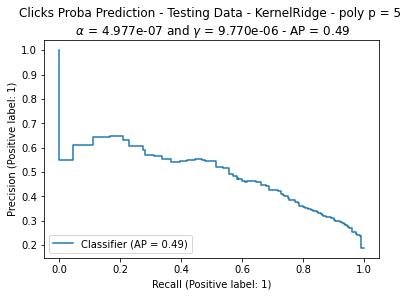

In [11]:
# =============================================================================
# TESTING WITH INDIVIDUAL CUSTOMER DATA
# =============================================================================

X_test = np.asarray(test[['Currently Insured', 'Number of Vehicles', 'Number of Drivers', 'Marital Status','rank']])
Y_test = np.asarray(test[['click']])


features_test = poly.fit_transform(X_test)
pred = output_model.predict(features_test)
pred = np.where(pred<0,0,pred)

rmse = mean_squared_error(Y_test, pred)**0.5

Y_test_bool=np.where(Y_test.reshape(-1)<0.5,0,1)
pred_boll=np.where(pred.reshape(-1)<0.5,0,1)
AP = average_precision_score(Y_test_bool,pred)
print(AP)


display = PrecisionRecallDisplay.from_predictions(Y_test_bool,pred)#, name="LinearSVC")
if method == 'KR':
    plt.title("Clicks Proba Prediction - Testing Data - KernelRidge - poly p = %d \n $\\alpha$ = %.3e and $\\gamma$ = %.3e - AP = %.2f" % (degree_, optimal_alpha, optimal_gamma, AP) )
    plt.savefig("%s/Precision_Recall-KernelRidge-poly_p=%d.pdf" % (path,degree_),  bbox_inches='tight')

elif method == 'RBF':
    plt.title("Clicks Proba Prediction - Testing Data - KernelRidge - Gaussian RBF \n $\\alpha$ = %.3e and $\\gamma$ = %.3e - AP = %.2f" % (optimal_alpha, optimal_gamma, AP) )
    plt.savefig("%s/Precision_Recall-KernelRidge-GaussianRBF.pdf" % path,  bbox_inches='tight')

elif method == 'R':
    plt.title("Clicks Proba Prediction - Testing Data - Ridge \n $\\alpha$ = %.3e - AP = %.2f" % (optimal_alpha, AP) )    
    plt.savefig("%s/Precision_Recall-Ridge.pdf" % path,  bbox_inches='tight')

